In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate, learning_curve, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# SoH Prediction

In [5]:
df = pd.read_csv('df_clean.csv')

#prepare features and target
feature_cols = ['V_min','V_max','V_mean', 'I_min','I_max', 'I_mean', 'T_min','T_max', 'T_mean', 'cycle','Capacity', 'duration_s']
target_col = 'SOH'

x = df[feature_cols].values 
y = df[target_col].values


print("\nStarting 5-Fold Cross Validation...")
# Initialize Random Forest 
rf_model = RandomForestRegressor(n_estimators=200, min_samples_split=2, bootstrap=True, max_depth=20,  min_samples_leaf=1,  random_state=42, n_jobs=-1)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_results = cross_validate(
    rf_model, x, y, cv=kf,
    scoring=['r2', 'neg_mean_absolute_error'],
    return_train_score=True
)

print("\nCross-Validation Results:")
print("CV Mean Train MAE:", -cv_results['train_neg_mean_absolute_error'].mean())
print("CV Mean Test MAE:", -cv_results['test_neg_mean_absolute_error'].mean())
print("CV Mean Train R2:", cv_results['train_r2'].mean())
print("CV Mean Test R2:", cv_results['test_r2'].mean())


Starting 5-Fold Cross Validation...

Cross-Validation Results:
CV Mean Train MAE: 0.010219758172045016
CV Mean Test MAE: 0.026947071423138215
CV Mean Train R2: 0.9999691477959228
CV Mean Test R2: 0.9998278614198364


In [9]:
 #Splitting data into Training/Testing (80% / 20%)
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42)

# Train Random Forest 
print("\nStarting Random Forest Model Training...")
rf_model.fit(x_train, y_train)
print("Training Complete.")

# Predict and Evaluate
y_pred = rf_model.predict(x_test)

# Calculate performance metrics
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n Random Forest Model Performance (SOH Prediction)")
print(f"Mean Absolute Error (MAE): {mae:.3f} % SOH")
print(f"R-squared (R2) Score: {r2:.4f}")


Starting Random Forest Model Training...
Training Complete.

 Random Forest Model Performance (SOH Prediction)
Mean Absolute Error (MAE): 0.022 % SOH
R-squared (R2) Score: 1.0000


In [14]:
#parameters grid
param_grid = {
    'n_estimators': [200, 500],
    'max_depth': [20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', None],
    'bootstrap': [True]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=5, # 5-fold cross-validation will be performed on the training data
    verbose=2,
    n_jobs=-1,  # Use all available cores for faster computation
)

# Fit the grid search to the training data
print("Starting Grid Search...")
grid_search.fit(x_train, y_train)
print("Grid Search complete.")

# Retrieve the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_estimator = grid_search.best_estimator_

print("\n--- Grid Search Results ---")
print(f"Best Cross-Validation R2 Score (averaged): {best_score:.4f}")
print(f"Best Parameters Found: {best_params}")

Starting Grid Search...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Grid Search complete.

--- Grid Search Results ---
Best Cross-Validation R2 Score (averaged): 0.9583
Best Parameters Found: {'bootstrap': True, 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


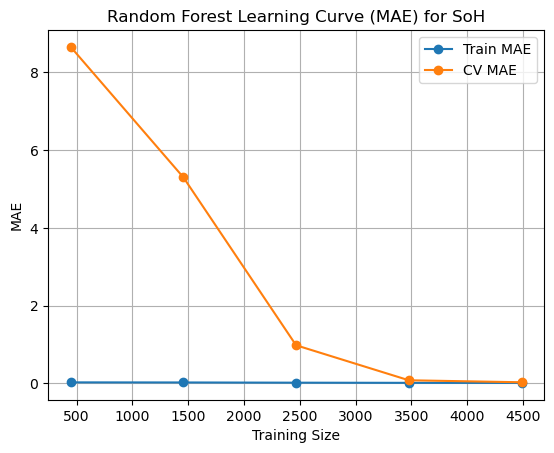

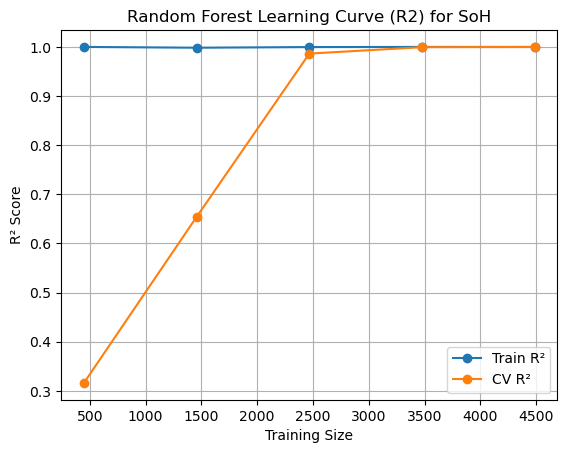

In [11]:
# Learning Curve MAE
train_sizes_mae, train_scores_mae, test_scores_mae = learning_curve(
    rf_model, x, y, cv=kf, scoring='neg_mean_absolute_error', #for mae
    train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
)

train_mae = -np.mean(train_scores_mae, axis=1)
test_mae  = -np.mean(test_scores_mae, axis=1)

plt.figure()
plt.plot(train_sizes_mae, train_mae, 'o-', label='Train MAE')
plt.plot(train_sizes_mae, test_mae, 'o-', label='CV MAE')
plt.xlabel("Training Size")
plt.ylabel("MAE")
plt.title("Random Forest Learning Curve (MAE) for SoH")
plt.legend()
plt.grid(True)
plt.show()


# Learning Curve for R²
train_sizes_R2, train_scores_R2, test_scores_R2 = learning_curve(
    rf_model, x, y, cv=kf, scoring='r2',  #  scoring is r2 now
    train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
)

train_r2 = train_scores_R2.mean(axis=1)
test_r2 = test_scores_R2.mean(axis=1)

plt.figure()
plt.plot(train_sizes_R2, train_r2, 'o-', label='Train R²')
plt.plot(train_sizes_R2, test_r2, 'o-', label='CV R²')
plt.xlabel("Training Size")
plt.ylabel("R² Score")
plt.title("Random Forest Learning Curve (R2) for SoH")
plt.legend()
plt.grid(True)
plt.show()




Top 5 Important Features for SoH (Permutation Importance):
Capacity    24.339142
T_min        0.008186
T_mean       0.006247
V_mean       0.006023
cycle        0.003570
dtype: float64


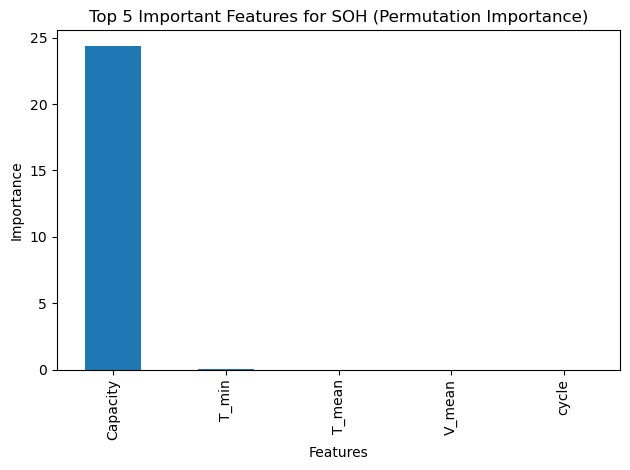

In [53]:
# PERMUTATION FEATURE IMPORTANCE (for SoH)
# This shows which input variables were most important for predicting SOH.
perm_soh = permutation_importance(rf_model, x_test, y_test, scoring='neg_mean_absolute_error')
perm_importance_soh = pd.Series(perm_soh.importances_mean, index=feature_cols).sort_values(ascending=False)

print("\nTop 5 Important Features for SoH (Permutation Importance):")
print(perm_importance.head(5))
perm_importance.head(5).plot(kind='bar')
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Top 5 Important Features for SOH (Permutation Importance)")
plt.tight_layout()
plt.show()


In [61]:
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (4487, 12)
y_train shape: (4487,)
x_test shape: (1122, 12)
y_test shape: (1122,)


# RUL PREDICTION

In [11]:
df_rul = pd.read_csv("df_complete_with_rul.csv")

# FEATURES & TARGET 
rul_feature_cols = ['V_min','V_max','V_mean', 'I_min','I_max', 'I_mean', 'T_min','T_max', 'cycle', 'T_mean', 'Capacity', 'duration_s','EOL_cycle','SOH']
rul_target_col = 'RUL'

X = df_rul[rul_feature_cols].values 
Y = df_rul[rul_target_col].values

# Initialize Random Forest 
rf_rul_model = RandomForestRegressor(n_estimators=200,min_samples_split=2, bootstrap=True, max_depth=20,  min_samples_leaf=1,  random_state=42, n_jobs=-1)

print("\n5-Fold Cross Validation...")
rul_cv_results = cross_validate(
    rf_rul_model, X, Y, cv=kf,
    scoring=['r2', 'neg_mean_absolute_error'],
    return_train_score=True
)

print("\nCross-Validation Results:")

print("RUL CV Mean Train MAE:", -rul_cv_results['train_neg_mean_absolute_error'].mean())
print("RUL CV Mean Test MAE:", -rul_cv_results['test_neg_mean_absolute_error'].mean())
print("CV Mean Train R2:", cv_results['train_r2'].mean())
print("RUL CV Mean Test R2:", rul_cv_results['test_r2'].mean())

 #Splitting data into Training/Testing (80% / 20%)
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

# Train Random Forest 
print("\nStarting Random Forest Model Training...")
rf_rul_model.fit(X_train, Y_train)
print("Training Complete.")

# Predict and Evaluate
Y_pred = rf_rul_model.predict(X_test)

# Calculate performance metrics
mae = mean_absolute_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)

print("\n Random Forest Model Performance (RUL Prediction)")
print(f"Mean Absolute Error (MAE): {mae:.3f} % RUL")
print(f"R-squared (R2) Score: {r2:.4f}")


5-Fold Cross Validation...

Cross-Validation Results:
RUL CV Mean Train MAE: 1.3899065217841107
RUL CV Mean Test MAE: 3.710848811498066
CV Mean Train R2: 0.9999691477959228
RUL CV Mean Test R2: 0.9947391367795457

Starting Random Forest Model Training...
Training Complete.

 Random Forest Model Performance (RUL Prediction)
Mean Absolute Error (MAE): 3.336 % RUL
R-squared (R2) Score: 0.9960


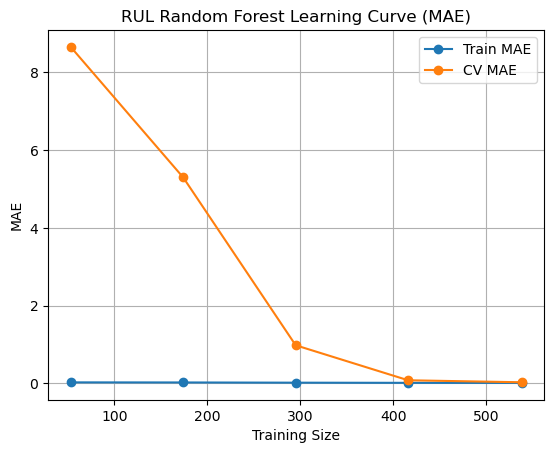

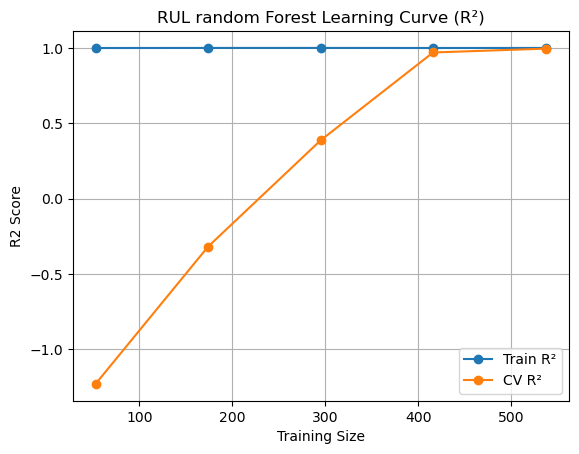

In [19]:
#Learning Curve MAE
rul_train_sizes_mae, rul_train_scores_mae, rul_test_scores_mae = learning_curve(
    rf_model, X, Y, cv=kf, scoring='neg_mean_absolute_error', #for mae
    train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
)

rul_train_mae = -np.mean(train_scores_mae, axis=1)
rul_test_mae  = -np.mean(test_scores_mae, axis=1)

plt.figure()
plt.plot(rul_train_sizes_mae, rul_train_mae, 'o-', label='Train MAE')
plt.plot(rul_train_sizes_mae, rul_test_mae, 'o-', label='CV MAE')
plt.xlabel("Training Size")
plt.ylabel("MAE")
plt.title("RUL Random Forest Learning Curve (MAE)")
plt.legend()
plt.grid(True)
plt.show()

#Learning Curve for R2
rul_train_sizes_R2, rul_train_scores_R2, rul_test_scores_R2 = learning_curve(
    rf_model, X, Y, cv=kf, scoring='r2',  #  scoring is r2 now
    train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
)

rul_train_r2 = rul_train_scores_R2.mean(axis=1)
rul_test_r2 = rul_test_scores_R2.mean(axis=1)

plt.figure()
plt.plot(rul_train_sizes_R2, rul_train_r2, 'o-', label='Train R²')
plt.plot(rul_train_sizes_R2, rul_test_r2, 'o-', label='CV R²')
plt.xlabel("Training Size")
plt.ylabel("R2 Score")
plt.title("RUL random Forest Learning Curve (R²)")
plt.legend()
plt.grid(True)
plt.show()


Top 5 Important Features (Permutation Importance) for RUL:
EOL_cycle    33.916141
SOH          29.002896
Capacity     28.430993
cycle        17.842896
T_min         1.985363
dtype: float64


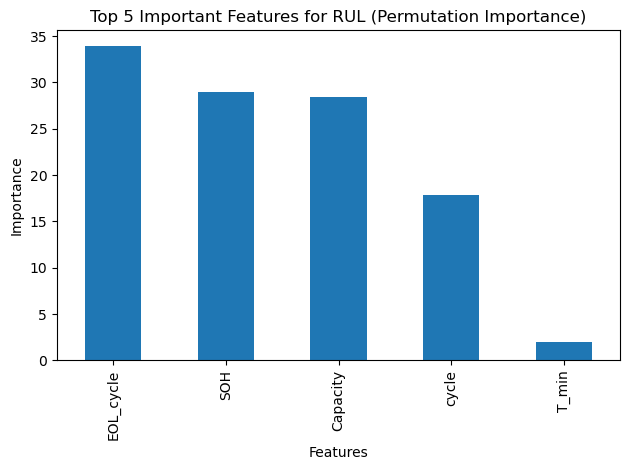

In [51]:
# PERMUTATION IMPORTANCE (for RUL)
perm_rul = permutation_importance(rf_rul_model, X_test, Y_test, scoring='neg_mean_absolute_error')
perm_importance_rul = pd.Series(perm_rul.importances_mean, index=rul_feature_cols).sort_values(ascending=False)

print("\nTop 5 Important Features (Permutation Importance) for RUL:")
print(perm_importance_rul.head(5))

perm_importance_rul.head(5).plot(kind='bar')
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Top 5 Important Features for RUL (Permutation Importance)")
plt.tight_layout()
plt.show()



In [89]:
#parameters grid
param_grid = {
    'n_estimators': [200, 500],
    'max_depth': [20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', None],
    'bootstrap': [True]
}
# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_rul_model,
    param_grid=param_grid,
    cv=5, #  5-fold cross-validation will be performed on the training data
    verbose=2,
    n_jobs=-1,  # Use all available cores for faster computation
)

# Fit the grid search to the training data
print("Starting Grid Search...")
grid_search.fit(X_train, Y_train)
print("Grid Search complete.")

# Retrieve the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_estimator = grid_search.best_estimator_

print("\n--- Grid Search Results ---")
print(f"Best Cross-Validation R2 Score (averaged): {best_score:.4f}")
print(f"Best Parameters Found: {best_params}")

Starting Grid Search...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Grid Search complete.

--- Grid Search Results ---
Best Cross-Validation R2 Score (averaged): 0.9929
Best Parameters Found: {'bootstrap': True, 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [58]:
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)


X_train shape: (538, 14)
Y_train shape: (538,)
X_test shape: (135, 14)
Y_test shape: (135,)
